# Earth Lab Capstone Project: Where can soil moisture improve rainfall-triggered landslide predictability?

## Author: Jacquelyn Witte

## This Notebook examines the relationship between SMAP and ESA CCI soil moisture and GPM precipitation for Landslides in the US

- Based on Landslide events from the NASA Global Landslide Catalog
- Using Landslide locations over Colorado as a workflow example

In [1]:
import os
from glob import glob

import datetime as dt
import earthpy as et
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.2)

In [2]:
def read_smap(filepath, index):
    """
    Reads SMAP data and returns the variable of interest.
    
    Parameters
    ----------
    filepath: Str
        File path of a SMAP L3 HDF5 file
        
    group_id: String
        Groups within the file to access
        
    index: int
        Index associated with the variable to retrieve
    
    Returns
    -------
    data: 2D numpy.ndarray (lat, lon)
    date: Date String yyyymmdd
    """
    # Read the file
    group_id = 'Soil_Moisture_Retrieval_Data_PM'
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        data_id = list(f[group_id].keys())[index]
        data = f[group_id][data_id][:,:]
        data[data == f[group_id][data_id].attrs['_FillValue']] = np.nan
        
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[5]
        yyyy = int(yyyymmdd[0:4])
        mm = int(yyyymmdd[4:6])
        dd = int(yyyymmdd[6:8])
        date=dt.datetime(yyyy,mm,dd)
    return data, date

In [3]:
def findfile(input_files, input_date):
    """
    Returns a single file from a list of files
    
    Parameters
    ----------
    input_files: List of strings
        List of full path to the file
        
    input_date: String
        YYYYMMDD format
        
    Returns
    -------
    file: Str
    """
    file = [x for x in input_files if re.findall(input_date, x)]
    if not file:
        raise ValueError('Date does not exist for '+input_date)
    return file

In [4]:
def nearestneighbor_ncdf(input_file, parameter, loc):
    """
    Extracts nearest neighbor value based on location and desired parameter. 
    
    Parameters
    ----------   
    input_file: Str - full path to a single file
    
    parameter: Str 
    
    loc: tuple (degree longtitude, degree latitude)
    
    Returns
    -------
    float
    """
    # read the netcdf file
    try:
        data_xr = xr.open_dataset(input_file).squeeze()
    except IOError:
        print("File not accessible")
    finally:
        data_xr.close()
    
    # subset the file
    res = data_xr[parameter].sel(indexers={
            'lon': loc[0],
            'lat': loc[1]},
            method="nearest")
    return float(res.values)

### Choose the state 

In [5]:
westernUS = ['Colorado', 'California', 'Oregon', 'Washington']
state = westernUS[1]

### Read and subset to Colorado Landslides >= year 2015 (SMAP data starts in 2015)

In [6]:
# Read the GLC file
glc_file = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 
                        'landslide', 'nasa_global_landslide_catalog_point.csv')

glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                glc['admin_division_name'] == state) & (
                glc['landslide_trigger'] != 'freeze_thaw') & (
                glc['landslide_trigger'] != 'snowfall_snowmelt') & (
                glc['landslide_trigger'] != 'earthquake') & (
                glc['landslide_trigger'] != 'leaking_pipe') & (
                glc['landslide_trigger'] != 'no_apparent_trigger') & (
                glc['landslide_trigger'] != 'other')              & (
                glc['landslide_trigger'] != 'unknown')
            ]
# convert to pandas datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co_gt2015 = glc_co[glc_co.index > '2015-04-01']

print(glc_co_gt2015.shape)
print(np.unique(glc_co_gt2015['landslide_trigger']))
print(np.unique(glc_co_gt2015['landslide_category']))
print(glc_co_gt2015.columns)
glc_co_gt2015.tail()

(315, 31)
['continuous_rain' 'downpour' 'flooding' 'rain']
['debris_flow' 'earth_flow' 'landslide' 'mudslide' 'rock_fall'
 'translational_slide']
Index(['OBJECTID', 'Shape', 'source_name', 'source_link', 'event_id',
       'event_date', 'event_time', 'event_title', 'event_description',
       'location_description', 'location_accuracy', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'fatality_count', 'injury_count', 'storm_name', 'photo_link',
       'comments', 'event_import_source', 'event_import_id', 'latitude',
       'longitude', 'country_name', 'country_code', 'admin_division_name',
       'gazetteer_closest_point', 'gazetteer_distance', 'submitted_date',
       'last_edited_date'],
      dtype='object')


,OBJECTID,Shape,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,...,event_import_id,latitude,longitude,country_name,country_code,admin_division_name,gazetteer_closest_point,gazetteer_distance,submitted_date,last_edited_date
date,,,,,,,,,,,,,,,,,,,,,
2018-12-08 01:18:20,7970501,"(-117.32589369199997, 33.664393062000045)",KTLA,https://ktla.com/news/local-news/evacuations-o...,14442,2018-12-08 01:18:20,unknown,Lake Elsinore Debris Flow,Heavy rains triggered a debris flow and mud to...,"Lake Elsinore, California",...,NaN,33.664393,-117.325894,United States,US,California,Lake Elsinore,5.50,2020-07-31 00:18:20,2022-04-23 06:31:41
2018-12-10 21:35:55,7966440,"(-118.589518167, 34.067957584000055)",LA Times,https://www.latimes.com/local/lanow/la-me-ln-t...,14097,2018-12-10 21:35:55,05:00,Landslide on Topanga Canyon Blvd. (California 22),A landslide occurred on Topanga Canyon Blvd. i...,Between Fernwood Pacific Dr. and the Pacific C...,...,NaN,34.067958,-118.589518,United States,US,California,Santa Monica Municipal,14.11,2020-05-06 20:35:55,2022-04-23 06:28:52
2018-12-28 20:00:00,7980714,"(-123.08468427999998, 40.767431000000045)",North Coast Journal,https://www.northcoastjournal.com/NewsBlog/arc...,13298,2018-12-28 20:00:00,20:00,State Route 299 Landslide,State Route 299 was hit by a landslide of rock...,"Mile 40 CA-299, Junction City, California, 96048",...,NaN,40.767431,-123.084684,United States,US,California,Dedrick,11.98,2019-01-22 21:11:18,2022-04-23 06:38:35
2019-01-05 19:00:00,7988475,"(-118.93595899999997, 34.04521900000003)",Patch,https://patch.com/california/malibu/pch-remain...,13289,2019-01-05 19:00:00,19:00,Pacific Coast Highway Mudflow at Mulholland Hi...,A small storm caused a mudflow at PCH and Mulh...,"Pacific Coast Highway and Mulholland Highway, ...",...,NaN,34.045219,-118.935959,United States,US,California,Point Mugu Naval Air Station,18.90,2019-01-22 16:46:36,2022-04-23 06:43:49
2020-05-06 12:15:26,7994035,"(-118.94053945299999, 34.04560759000003)",CBS News,https://www.cbsnews.com/news/mudslide-closes-p...,14209,2020-05-06 12:15:26,unknown,Mudslide at Leo Carillo State Beach,A mudslide occurred on the Pacific Coast Highw...,Leo Carillo State Beach along the Pacific Coas...,...,NaN,34.045608,-118.940539,United States,US,California,Point Mugu Naval Air Station,18.51,2020-05-09 12:15:26,2022-04-23 06:23:19


### Get all SMAP, ESA and GPM data files, sorted
 - ESA = Percent of Saturation Soil Moisture
 - SMAP = Volumetric soil moisture in cm3/cm3
 - GPM = Precipitation accumulation in mm

In [7]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone')
smap_files = sorted(glob(os.path.join(data_dir, 'smap_9km', '*.h5')))

gpm_files = sorted(glob(os.path.join(data_dir, 'gpm_westernUS', '*nc4')))

esa_files = sorted(glob(os.path.join(data_dir, 'esa_soil_moisture', 
                                     '*ACTIVE*nc')))

# Print a sample as a sanity check
print(os.path.exists(smap_files[0]))
print(os.path.exists(gpm_files[0]))
print(os.path.exists(esa_files[0]))

True
True
True


#### These are SMAP variables that can provide key information in characterizing landslides over Colorado

| Variable Name | Index | Units |
| ----------- | ----------- | ----------- |
| soil_moisture | 24 | cm<sup>3</sup>/cm<sup>3</sup> |
| radar_water_body_fraction | 15 | N/A | 
| vegetation_opacity | 46 | N/A |
| vegetation_water_content | 50 | kg/m<sup>2</sup> |

### Load the EASE2 grid lon and lat datasets to subset SMAP data. 
- These can be found on the NSIDC website: https://nsidc.org/data/ease/tools#geo_data_files

> Brodzik, M. J., B. Billingsley, T. Haran, B. Raup, M. H. Savoie. 2012. EASE-Grid 2.0: Incremental but Significant Improvements for Earth-Gridded Data Sets. ISPRS International Journal of Geo-Information, 1(1):32-45, doi:10.3390/ijgi1010032. http://www.mdpi.com/2220-9964/1/1/32.

In [8]:
# Reshape to dimensions of the SMAP data above
sm_data, date = read_smap(smap_files[1], 24)

lats = np.fromfile(os.path.join(data_dir, 'smap_9km',
                                'EASE2_M09km.lats.3856x1624x1.double'),
                   dtype=np.float64).reshape(sm_data.shape)
lons = np.fromfile(os.path.join(data_dir, 'smap_9km',
                                'EASE2_M09km.lons.3856x1624x1.double'),
                   dtype=np.float64).reshape(sm_data.shape)
sm_data.shape

(1624, 3856)

### Read the SMAP, ESA CCI and GPM data 
- Two dataframes are generated
    1. Colocated to all the Landslide events
    2. Precipitation measurements going back 7 day from each landslide event and indexed to Landslide ID

In [9]:
precip7d_date = []
precip7d = []
precip_accum = []
smap_sm = []
smap_wc = []
esa_sm = []
landslide_date = []
landslide_id = []
landslide7d_id = []
landslide_cat = []
landslide_trig = []
landslide_sz = []
lat = []
lon = []
periods = 7
count_down = []

for i, ls_date in enumerate(glc_co_gt2015.index):
#for i, ls_date in enumerate(glc_co_gt2015.index[1:len(glc_co_gt2015.index)]):

    # Get -7 days from the event
    glc_date = pd.date_range(ls_date, periods=periods,
                             freq='-1D').strftime('%Y%m%d')

    # Append landslide metadata
    landslide_date.append(ls_date)
    lat.append(glc_co_gt2015.latitude[i])
    lon.append(glc_co_gt2015.longitude[i])
    landslide_id.append(glc_co_gt2015.event_id[i])
    landslide_cat.append(glc_co_gt2015.landslide_category[i])
    landslide_trig.append(glc_co_gt2015.landslide_trigger[i])
    landslide_sz.append(glc_co_gt2015.landslide_size[i])

    # Take the +/- 0.3 deg mean around the Landslide event
    N_lat = glc_co_gt2015.latitude[i]+0.15
    S_lat = glc_co_gt2015.latitude[i]-0.15
    W_lon = glc_co_gt2015.longitude[i]-0.15
    E_lon = glc_co_gt2015.longitude[i]+0.15
    subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)

    #print(i, ls_date, glc_co_gt2015.latitude[i], glc_co_gt2015.longitude[i])
    
    # Initialize data
    sm_mean = []
    vegwc_mean = []
    esa_mean = []
    precip = []
    countd = periods
 
    # loop over the 7 days
    for yyyymmdd in glc_date:
        
        # Find the SMAP file
        filesm = findfile(smap_files, yyyymmdd)
        # Retrieve the SMAP variables
        sm, time_t = read_smap(filesm[0], 24)
        vegwc, t = read_smap(filesm[0], 50)
        # Calculate the SMAP mean
        sm_mean.append(np.nanmean(sm[subset]))
        vegwc_mean.append(np.nanmean(vegwc[subset]))

        # Get the Landslide location
        loc = (glc_co_gt2015.longitude[i], glc_co_gt2015.latitude[i])

        # Find the ESA soil moisture file
        file_esa = findfile(esa_files, yyyymmdd) 
        # Get the nearest neighbor value of % soil moisture
        res_esa = nearestneighbor_ncdf(file_esa[0], 'sm', loc)
        # Replace negative values with NaN
        if res_esa < 0.0:
            esa_mean.append(np.nan)
        else:
            esa_mean.append(res_esa)
        
        # find the GPM file
        file_gpm = findfile(gpm_files, yyyymmdd) 
        
        precip7d.append(nearestneighbor_ncdf(file_gpm[0], 
                             'precipitationCal', loc))
        landslide7d_id.append(glc_co_gt2015.event_id[i])
        # Append the date
        precip7d_date.append(yyyymmdd)

        precip.append(nearestneighbor_ncdf(file_gpm[0], 
                             'precipitationCal', loc))
        
        # Append countdown
        count_down.append(countd)
        countd -= 1

    # Append the summary values for the 7 day period
    smap_sm.append(np.nanmax(sm_mean))
    smap_wc.append(np.nanmax(vegwc_mean))
    esa_sm.append(np.nanmax(esa_mean))
    precip_accum.append(np.nansum(precip))
    
# Create a soils and precip dataFrame
landslide_df = pd.DataFrame(smap_sm,
                            index=pd.to_datetime(landslide_date), 
                            columns=['smap_sm'])
landslide_df['veg_water_content'] = smap_wc
landslide_df['esa_sm_percent'] = esa_sm
landslide_df['precip_accum_mm'] = precip_accum

# Add the Landslide metadata
landslide_df['glc_lat'] = lat
landslide_df['glc_lon'] = lon
landslide_df['landslide_id'] = landslide_id
landslide_df['landslide_category'] = landslide_cat
landslide_df['landslide_trigger'] = landslide_trig
landslide_df['landslide_size'] = landslide_sz

# Create the 7day precipitation dataFrame
landslide_precip7d_df = pd.DataFrame(precip7d,
                            index=pd.to_datetime(precip7d_date), 
                            columns=['precip_mm'])
landslide_precip7d_df['landslide_id'] = landslide7d_id

# Add the cumulative precipitation
accum = []
for i, data in landslide_precip7d_df.groupby("landslide_id"):
    accum.extend(np.flip(data['precip_mm'].cumsum().values))

landslide_precip7d_df['precip_accum_mm'] = accum
landslide_precip7d_df['days-to-landslide'] = count_down

# Add the normalized precipitation
accum_norm = []
for i, data in landslide_precip7d_df.groupby("landslide_id"):
    res = data['precip_accum_mm']/data['precip_accum_mm'].mean()
    accum_norm.append(res.max())

landslide_df['precip_accum_norm'] = accum_norm

In [10]:
landslide_df.head()

,smap_sm,veg_water_content,esa_sm_percent,precip_accum_mm,glc_lat,glc_lon,landslide_id,landslide_category,landslide_trigger,landslide_size,precip_accum_norm
2015-04-09 00:00:00,0.147053,2.346987,NaN,0.112326,33.4418,-117.6454,7164,landslide,rain,small,1.750000
2015-04-09 00:00:00,0.147053,2.346987,NaN,0.112326,33.4418,-117.6454,7166,landslide,rain,small,1.750000
2015-06-12 16:50:00,0.085951,1.232859,0.511320,7.061603,35.1433,-118.4688,6959,mudslide,downpour,small,1.275103
2015-07-01 15:00:00,0.192198,4.406042,68.291466,9.907128,38.6987,-119.7712,7088,mudslide,downpour,small,1.303973
2015-07-18 15:20:00,0.092204,2.786711,25.834671,28.161337,34.1036,-116.9702,7240,rock_fall,downpour,small,1.000000


In [11]:
landslide_precip7d_df.head()

,precip_mm,landslide_id,precip_accum_mm,days-to-landslide
2015-04-09,0.000000,7164,7.061603,7
2015-04-08,0.000000,7164,7.030960,6
2015-04-07,0.000000,7164,6.835102,5
2015-04-06,0.112326,7164,6.835102,4
2015-04-05,0.000000,7164,5.725587,3


### Plot soil time series from each co-located Landslide

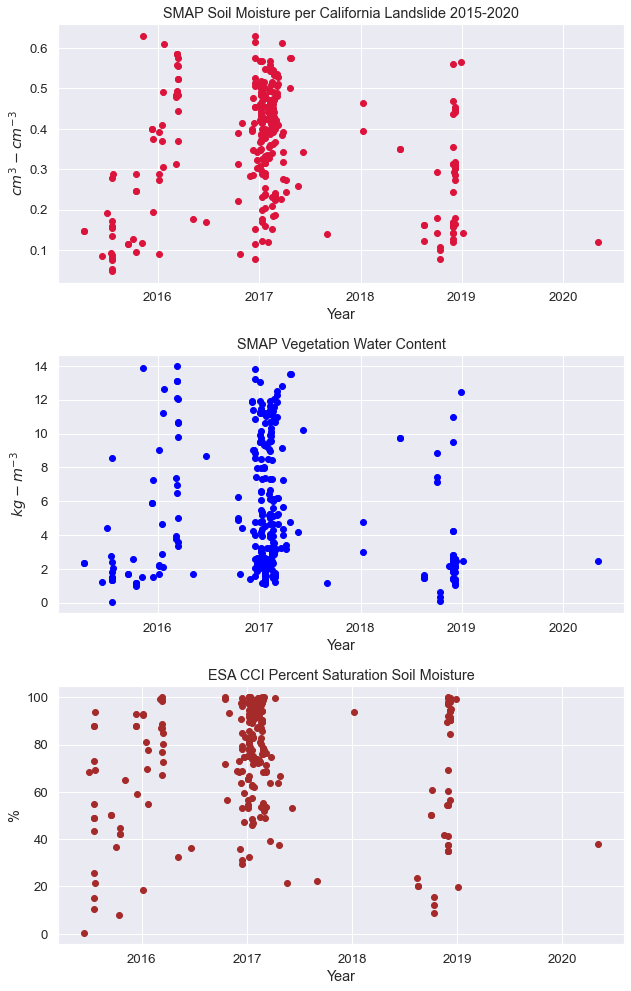

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(9, 14))

for id, df in landslide_df.groupby("landslide_id"):
    ax1.plot(df.index, df['smap_sm'],
            marker='o', linestyle='none', color='crimson')
    ax2.plot(df.index, df['veg_water_content'],
            marker='o', linestyle='none', color='blue')
    ax3.plot(df.index, df['esa_sm_percent'], 
            marker='o', linestyle='none', color='brown')

ax1.set(xlabel='Year',
       ylabel='$cm^3 - cm^{-3}$',
       title='SMAP Soil Moisture per '+state+' Landslide 2015-2020')

ax2.set(xlabel='Year',
       ylabel='$kg-m^{-3}$',
       title='SMAP Vegetation Water Content')

ax3.set(xlabel='Year',
       ylabel='%',
       title='ESA CCI Percent Saturation Soil Moisture')

plt.tight_layout()
plt.savefig(os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'soilmoisture_timeseries_'+state+'.png'))

### Plot the cumulative precipitation going back 7 days

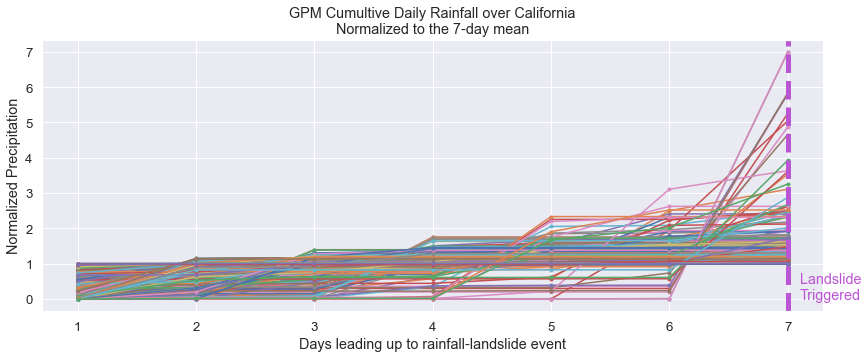

In [13]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in landslide_precip7d_df.groupby("landslide_id"):
    ax.plot(df['days-to-landslide'], 
            df['precip_accum_mm']/df['precip_accum_mm'].mean(), 
            marker='.')

#ax.invert_xaxis()
ax.axvline(x=7, ymin=0, color='mediumorchid', linestyle='dashed', linewidth=5)

ax.set(xlabel='Days leading up to rainfall-landslide event',
       ylabel='Normalized Precipitation',
       title='GPM Cumultive Daily Rainfall over '+state+'\nNormalized to the 7-day mean')
ax.text(7.1 ,0, 'Landslide\nTriggered', color='mediumorchid', fontsize='medium');

plt.savefig(os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'gpm_precip7d_normalized_timeseries_'+state+'.png'))

### Plot Precipitation vs SMAP Soil Moisture

In [14]:
colors = ['red', 'green', 'orange', 'blue', 'cyan', 'purple']

category = dict(zip(np.unique(landslide_df['landslide_category']), colors))
print(category)

trigger = dict(zip(np.unique(landslide_df['landslide_trigger']), colors))
print(trigger)

{'debris_flow': 'red', 'earth_flow': 'green', 'landslide': 'orange', 'mudslide': 'blue', 'rock_fall': 'cyan', 'translational_slide': 'purple'}
{'continuous_rain': 'red', 'downpour': 'green', 'flooding': 'orange', 'rain': 'blue'}


#### Plot by Landslide Category

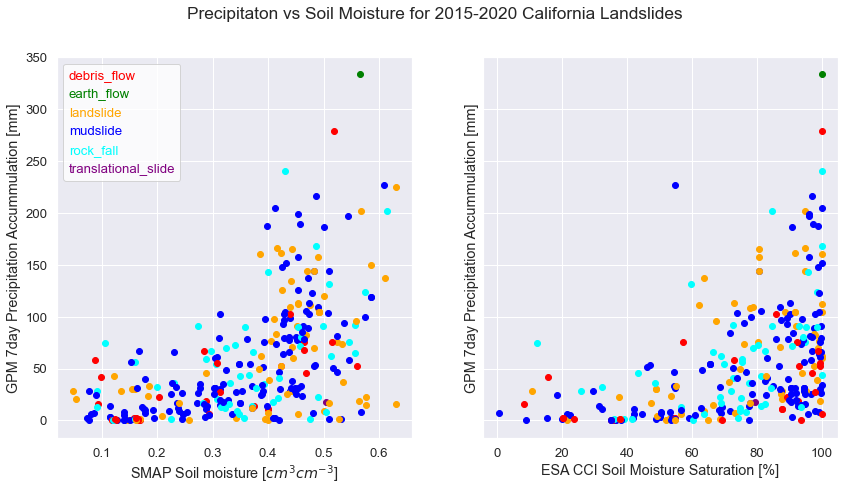

In [15]:
# Create a scatter plot
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 7),
                               sharey=True)

# SMAP
for id, df in landslide_df.groupby("landslide_id"):
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax1.scatter(df['smap_sm'], df['precip_accum_mm'],
                        color=category[cat])
            ax2.scatter(df['esa_sm_percent'], df['precip_accum_mm'],
                        color=category[cat])

ax1.set(xlabel='SMAP Soil moisture [$cm^3 cm^{-3}$]',
        ylabel='GPM 7day Precipitation Accummulation [mm]')
#ax1.set_ylim([-5, 100])

ax2.set(xlabel='ESA CCI Soil Moisture Saturation [%]',
        ylabel='GPM 7day Precipitation Accummulation [mm]')

# Add legend
leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# add an overall caption
fig.suptitle(
    'Precipitaton vs Soil Moisture for 2015-2020 '+state+' Landslides'
)


plt.savefig(os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'sm_VS_precip_2015_2020_category_'+state+'.png'));

#### Plot by Landslide Trigger

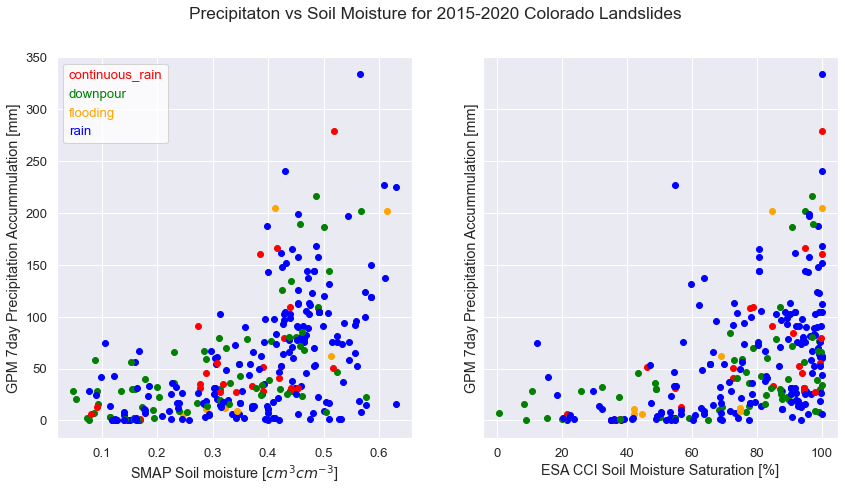

In [16]:
# Create a scatter plot
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 7),
                               sharey=True)

# SMAP
for id, df in landslide_df.groupby("landslide_id"):
    for cat in trigger:
        if df['landslide_trigger'][0] == cat:
            ax1.scatter(df['smap_sm'], df['precip_accum_mm'],
                        color=trigger[cat])
            ax2.scatter(df['esa_sm_percent'], df['precip_accum_mm'],
                        color=trigger[cat])

ax1.set(xlabel='SMAP Soil moisture [$cm^3 cm^{-3}$]',
        ylabel='GPM 7day Precipitation Accummulation [mm]')
#ax1.set_ylim([-5, 100])

ax2.set(xlabel='ESA CCI Soil Moisture Saturation [%]',
        ylabel='GPM 7day Precipitation Accummulation [mm]')

# Add legend
leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=trigger, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# add an overall caption
fig.suptitle(
    'Precipitaton vs Soil Moisture for 2015-2020 Colorado Landslides'
);


plt.savefig(os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'sm_VS_precip_2015_2020_trigger_'+state+'.png'));

### Plot Ratio of Normalize Precipitation to SMAP Soil Moisture
- By category and trigger

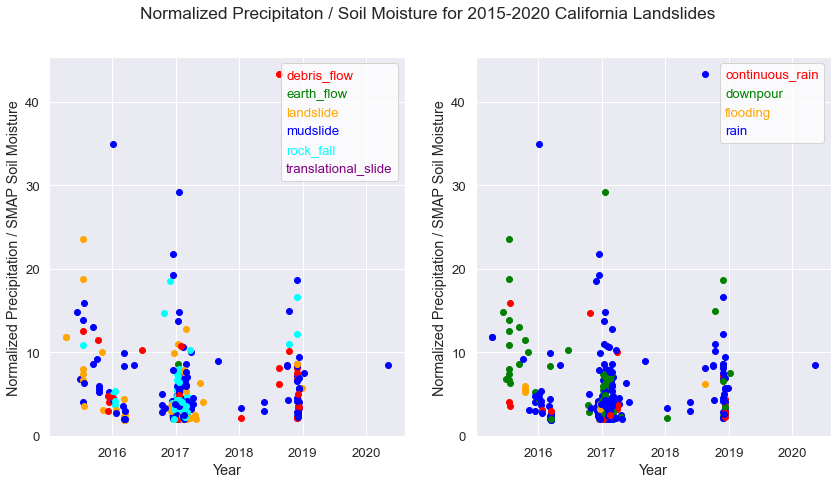

In [17]:
# Create a scatter plot
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))


# By Category
count = 1
for id, df in landslide_df.groupby("landslide_id"):
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax1.scatter(df.index[0], df['precip_accum_norm']/df['smap_sm'],
                        color=category[cat])
    count = count+1

# Rotating X-axis labels
#ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)

ax1.set(xlabel='Year',
        ylabel='Normalized Precipitation / SMAP Soil Moisture')


# Add legend
leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# By Trigger
count = 1
for id, df in landslide_df.groupby("landslide_id"):
    for cat in trigger:
        if df['landslide_trigger'][0] == cat:
            ax2.scatter(df.index[0], df['precip_accum_norm']/df['smap_sm'],
                        color=trigger[cat])
    count = count+1

ax2.set(xlabel='Year',
        ylabel='Normalized Precipitation / SMAP Soil Moisture')

# Add legend
leg = ax2.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=trigger, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)
    
# add an overall caption
fig.suptitle(
    'Normalized Precipitaton / Soil Moisture for 2015-2020 '+state+' Landslides'
);


### Look at outliers by creating box-whisker plots

Text(0.5, 1.0, 'SMAP')

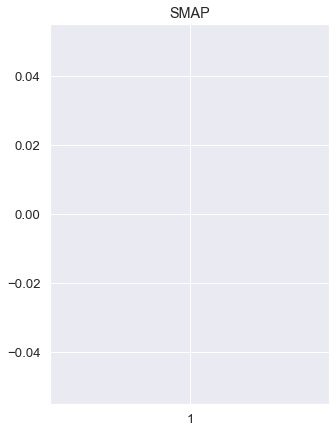

In [20]:
fig, ax = plt.subplots(figsize=(5, 7))

# plot box plot
red_sqr = dict(markerfacecolor='r', marker='s')
box = ax.boxplot(landslide_df['smap_sm'], flierprops=red_sqr)
ax.set_title('SMAP')


In [19]:
fly = box['fliers'][0]
outliers = fly.get_ydata()
outliers

array([], dtype=float32)